In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import torchaudio
from torch.utils.data import random_split

from dataLoader import RageDataset

In [11]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dataset = RageDataset("dataset", transform=transform)

# Sizes
total_size = len(dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size

# Split
train_dataset, test_dataset = random_split(
    dataset, [train_size, test_size]
)

# Loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)



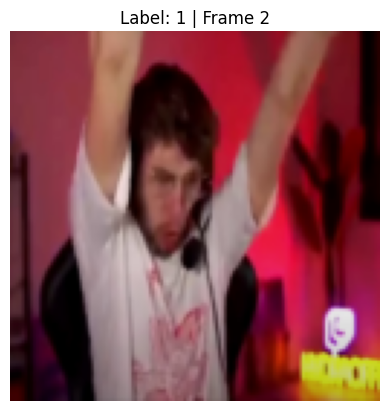

In [12]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Get the 2nd frame from the 1st video sample
sample = train_dataset[0]
frame = sample['frames'][1]  # shape: [3, H, W]

# Convert tensor to PIL Image for display
img = F.to_pil_image(frame)

# Show the image
plt.imshow(img)
plt.title(f"Label: {sample['label'].item()} | Frame 2")
plt.axis("off")
plt.show()

In [13]:
print(len(train_dataset)+len(test_dataset))
train_dataset[0]['frames'][1]

120


tensor([[[0.4627, 0.4745, 0.4824,  ..., 0.0392, 0.0863, 0.1373],
         [0.4706, 0.4824, 0.4902,  ..., 0.0431, 0.0941, 0.1451],
         [0.4745, 0.4863, 0.4941,  ..., 0.0431, 0.0980, 0.1451],
         ...,
         [0.2353, 0.2431, 0.2392,  ..., 0.7216, 0.7176, 0.7137],
         [0.2392, 0.2431, 0.2431,  ..., 0.7176, 0.7098, 0.7020],
         [0.2353, 0.2392, 0.2392,  ..., 0.6863, 0.6824, 0.6784]],

        [[0.1686, 0.1686, 0.1725,  ..., 0.0000, 0.0000, 0.0000],
         [0.1686, 0.1686, 0.1765,  ..., 0.0000, 0.0000, 0.0000],
         [0.1686, 0.1725, 0.1765,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.5373, 0.4510, 0.4549],
         [0.0000, 0.0000, 0.0000,  ..., 0.5608, 0.4824, 0.4549],
         [0.0000, 0.0000, 0.0000,  ..., 0.5176, 0.4549, 0.4196]],

        [[0.2157, 0.2196, 0.2235,  ..., 0.0000, 0.0000, 0.0000],
         [0.2196, 0.2196, 0.2275,  ..., 0.0000, 0.0000, 0.0000],
         [0.2196, 0.2235, 0.2275,  ..., 0.0000, 0.0000, 0.

In [15]:
class LSTMClassifierLateFusion(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super().__init__()

        # Vision module
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4)),
        )
        self.flatten_size = 32 * 4 * 4  # 512
        self.lstm = nn.LSTM(self.flatten_size, hidden_size, batch_first=True, bidirectional=True)

        # Audio module
        self.audio_net = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=11, stride=4, padding=5),
            nn.ReLU(),
            nn.Conv1d(8, 16, kernel_size=11, stride=4, padding=5),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(10),  # → [B, 16, 10]
            nn.Flatten(),              # → [B, 160]
        )

        # Fusion
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size * 2 + 160, num_classes)

    def forward(self, frames, audio):  # frames: [B, T, 3, 128, 128], audio: [B, 1, N]
        B, T, C, H, W = frames.size()

        # Vision path
        x = frames.view(B * T, C, H, W)
        feats = self.cnn(x)
        feats = feats.view(B, T, -1)  # [B, T, 512]
        _, (h_n, _) = self.lstm(feats)
        visual_feat = torch.cat((h_n[0], h_n[1]), dim=1)  # [B, 2*H]

        # Audio path
        audio_feat = self.audio_net(audio)  # [B, 160]

        # Fusion
        fused = torch.cat([visual_feat, audio_feat], dim=1)  # [B, 2*H + 160]
        out = self.fc(self.dropout(fused))
        return out


In [16]:
print("cuda" if torch.cuda.is_available() else "cpu")


cuda


In [17]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifierLateFusion(hidden_size=128, num_classes=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(50):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    print(f"\nEpoch {epoch+1}")
    for batch in tqdm(train_loader, desc="Training", leave=False):
        frames = batch['frames'].to(device)
        audio = batch['audio'].to(device)
        labels = batch['label'].to(device)

        outputs = model(frames, audio)

        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(dim=1) == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f} | Accuracy: {acc:.2f}%")

    # # --- Validation ---
    # model.eval()
    # val_loss = 0
    # val_correct = 0
    # val_total = 0

    # with torch.no_grad():
    #     for batch in tqdm(test_loader, desc="Validating", leave=False):
    #         frames = batch['frames'].to(device)
    #         audio = batch['audio'].to(device)
    #         labels = batch['label'].to(device)

    #         outputs = model(frames, audio)
    #         loss = criterion(outputs, labels)

    #         val_loss += loss.item()
    #         val_correct += (outputs.argmax(dim=1) == labels).sum().item()
    #         val_total += labels.size(0)

    # val_acc = 100 * val_correct / val_total
    # print(f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.2f}%")

    # # save the best model
    # if val_acc > 70 and acc > 70:
    #     print(f"Saving model_{epoch+1}.pth")
    #     torch.save(model.state_dict(), f"model_{epoch+1}.pth")


Epoch 1


Epoch 1 | Loss: 4.1750 | Accuracy: 53.12%


Val Loss: 1.4087 | Val Accuracy: 41.67%

Epoch 2


Epoch 2 | Loss: 4.1736 | Accuracy: 52.08%


Val Loss: 1.4122 | Val Accuracy: 41.67%

Epoch 3


Epoch 3 | Loss: 4.1501 | Accuracy: 53.12%


Val Loss: 1.4046 | Val Accuracy: 41.67%

Epoch 4


Epoch 4 | Loss: 4.1454 | Accuracy: 51.04%


Val Loss: 1.4053 | Val Accuracy: 41.67%

Epoch 5


Epoch 5 | Loss: 4.1494 | Accuracy: 51.04%


Val Loss: 1.4028 | Val Accuracy: 41.67%

Epoch 6


Epoch 6 | Loss: 4.1614 | Accuracy: 51.04%


Val Loss: 1.4020 | Val Accuracy: 41.67%

Epoch 7


Epoch 7 | Loss: 4.1634 | Accuracy: 51.04%


Val Loss: 1.4016 | Val Accuracy: 41.67%

Epoch 8


Epoch 8 | Loss: 4.1647 | Accuracy: 53.12%


Val Loss: 1.4039 | Val Accuracy: 41.67%

Epoch 9


Epoch 9 | Loss: 4.1384 | Accuracy: 54.17%


Val Loss: 1.4029 | Val Accuracy: 41.67%

Epoch 10


Epoch 10 | Loss: 4.1352 | Accuracy: 53.12%


Val Loss: 1.4044 | Val Accuracy: 41.67%

Epoch 11


Epoch 11 | Loss: 4.1529 | Accuracy: 53.12%


Val Loss: 1.4024 | Val Accuracy: 41.67%

Epoch 12


Epoch 12 | Loss: 4.1352 | Accuracy: 53.12%


Val Loss: 1.3994 | Val Accuracy: 37.50%

Epoch 13


Epoch 13 | Loss: 4.1411 | Accuracy: 53.12%


Val Loss: 1.4014 | Val Accuracy: 41.67%

Epoch 14


Epoch 14 | Loss: 4.1262 | Accuracy: 55.21%


Val Loss: 1.4054 | Val Accuracy: 41.67%

Epoch 15


Epoch 15 | Loss: 4.1172 | Accuracy: 56.25%


Val Loss: 1.4047 | Val Accuracy: 41.67%

Epoch 16


Epoch 16 | Loss: 4.1183 | Accuracy: 51.04%


Val Loss: 1.4024 | Val Accuracy: 37.50%

Epoch 17


Epoch 17 | Loss: 4.1048 | Accuracy: 53.12%


Val Loss: 1.4041 | Val Accuracy: 37.50%

Epoch 18


Epoch 18 | Loss: 4.1162 | Accuracy: 58.33%


Val Loss: 1.3986 | Val Accuracy: 41.67%

Epoch 19


Epoch 19 | Loss: 4.1056 | Accuracy: 58.33%


Val Loss: 1.3966 | Val Accuracy: 50.00%

Epoch 20


Epoch 20 | Loss: 4.1100 | Accuracy: 58.33%


Val Loss: 1.3973 | Val Accuracy: 50.00%

Epoch 21


Epoch 21 | Loss: 4.1041 | Accuracy: 61.46%


Val Loss: 1.3978 | Val Accuracy: 50.00%

Epoch 22


Epoch 22 | Loss: 4.1218 | Accuracy: 57.29%


Val Loss: 1.4005 | Val Accuracy: 45.83%

Epoch 23


Epoch 23 | Loss: 4.0991 | Accuracy: 57.29%


Val Loss: 1.4087 | Val Accuracy: 37.50%

Epoch 24


Epoch 24 | Loss: 4.0959 | Accuracy: 55.21%


Val Loss: 1.4137 | Val Accuracy: 37.50%

Epoch 25


Epoch 25 | Loss: 4.0851 | Accuracy: 55.21%


Val Loss: 1.4074 | Val Accuracy: 45.83%

Epoch 26


Epoch 26 | Loss: 4.0735 | Accuracy: 59.38%


Val Loss: 1.3985 | Val Accuracy: 45.83%

Epoch 27


Epoch 27 | Loss: 4.0637 | Accuracy: 64.58%


Val Loss: 1.4065 | Val Accuracy: 50.00%

Epoch 28


Epoch 28 | Loss: 4.0575 | Accuracy: 60.42%


Val Loss: 1.3999 | Val Accuracy: 45.83%

Epoch 29


Epoch 29 | Loss: 4.0497 | Accuracy: 61.46%


Val Loss: 1.4116 | Val Accuracy: 45.83%

Epoch 30


Epoch 30 | Loss: 4.0242 | Accuracy: 61.46%


Val Loss: 1.4254 | Val Accuracy: 41.67%

Epoch 31


Epoch 31 | Loss: 4.0170 | Accuracy: 63.54%


Val Loss: 1.4280 | Val Accuracy: 45.83%

Epoch 32


Epoch 32 | Loss: 3.9886 | Accuracy: 61.46%


Val Loss: 1.4443 | Val Accuracy: 45.83%

Epoch 33


Epoch 33 | Loss: 3.9419 | Accuracy: 62.50%


Val Loss: 1.4397 | Val Accuracy: 41.67%

Epoch 34


Epoch 34 | Loss: 3.9071 | Accuracy: 63.54%


Val Loss: 1.4710 | Val Accuracy: 41.67%

Epoch 35


Epoch 35 | Loss: 3.9976 | Accuracy: 61.46%


Val Loss: 1.4505 | Val Accuracy: 45.83%

Epoch 36


Epoch 36 | Loss: 3.7150 | Accuracy: 66.67%


Val Loss: 1.6460 | Val Accuracy: 37.50%

Epoch 37


Epoch 37 | Loss: 3.8957 | Accuracy: 59.38%


Val Loss: 1.4742 | Val Accuracy: 41.67%

Epoch 38


Epoch 38 | Loss: 3.6736 | Accuracy: 65.62%


Val Loss: 1.6935 | Val Accuracy: 33.33%

Epoch 39


Epoch 39 | Loss: 3.7408 | Accuracy: 62.50%


Val Loss: 1.5501 | Val Accuracy: 37.50%

Epoch 40


Epoch 40 | Loss: 4.0224 | Accuracy: 62.50%


Val Loss: 1.3917 | Val Accuracy: 62.50%

Epoch 41


Epoch 41 | Loss: 3.9583 | Accuracy: 59.38%


Val Loss: 1.4061 | Val Accuracy: 45.83%

Epoch 42


Epoch 42 | Loss: 3.8898 | Accuracy: 64.58%


Val Loss: 1.4944 | Val Accuracy: 37.50%

Epoch 43


Epoch 43 | Loss: 3.9069 | Accuracy: 60.42%


Val Loss: 1.4760 | Val Accuracy: 37.50%

Epoch 44


Epoch 44 | Loss: 3.9065 | Accuracy: 59.38%


Val Loss: 1.4302 | Val Accuracy: 41.67%

Epoch 45


Epoch 45 | Loss: 3.7840 | Accuracy: 69.79%


Val Loss: 1.4024 | Val Accuracy: 54.17%

Epoch 46


Epoch 46 | Loss: 3.8030 | Accuracy: 66.67%


Val Loss: 1.4244 | Val Accuracy: 50.00%

Epoch 47


Epoch 47 | Loss: 3.7417 | Accuracy: 67.71%


Val Loss: 1.4856 | Val Accuracy: 37.50%

Epoch 48


Epoch 48 | Loss: 3.6802 | Accuracy: 61.46%


Val Loss: 1.5206 | Val Accuracy: 37.50%

Epoch 49


Epoch 49 | Loss: 3.5998 | Accuracy: 61.46%


Val Loss: 1.5085 | Val Accuracy: 45.83%

Epoch 50


Epoch 50 | Loss: 3.5448 | Accuracy: 65.62%


Val Loss: 1.5240 | Val Accuracy: 45.83%


C:\Users\lizhe\AppData\Local\Temp\ipykernel_42952\8304659.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_42.pth'))  # Update wit


--- Testing ---


Test Loss: 0.9447 | Test Accuracy: 79.17%


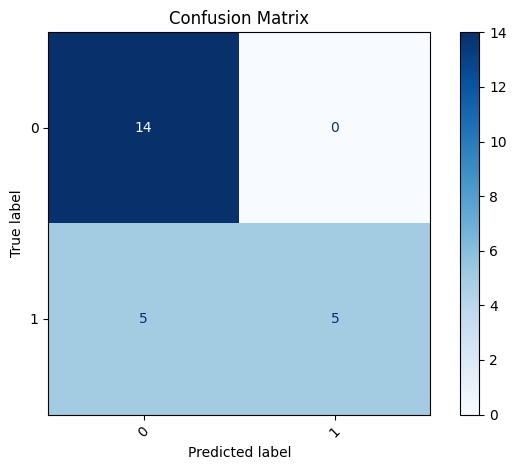


Classification Report:

              precision    recall  f1-score   support

           0     0.7368    1.0000    0.8485        14
           1     1.0000    0.5000    0.6667        10

    accuracy                         0.7917        24
   macro avg     0.8684    0.7500    0.7576        24
weighted avg     0.8465    0.7917    0.7727        24



In [18]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

print("\n--- Testing ---")

# Load the saved model
model.load_state_dict(torch.load('model_42.pth'))

model.eval()
test_loss = 0
test_correct = 0
test_total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing", leave=False):
        frames = batch['frames'].to(device)
        audio = batch['audio'].to(device)
        labels = batch['label'].to(device)

        outputs = model(frames, audio)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        test_correct += (outputs.argmax(dim=1) == labels).sum().item()
        test_total += labels.size(0)

        all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100 * test_correct / test_total
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

report = classification_report(all_labels, all_preds, digits=4)
print("\nClassification Report:\n")
print(report)
